**Import Necessary Libraries**

In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

**Define Functions for model and data preperation.**

In [21]:
def create_lstm_model(input_shape):
    model=Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=25),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss=lambda y_true, y_pred: weighted_loss(y_true, y_pred))
    return model

In [22]:
def weighted_loss(y_true, y_pred):
    weights = tf.range(1, tf.shape(y_true)[0]+1, dtype=tf.float32)
    #Exponential Weights
    weights = tf.math.exp(weights/ tf.reduce_max(weights))
    loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    return tf.reduce_mean(loss * weights) 

In [23]:
def prepare_data(df, sequence_length=60):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

    X, y = [],[]
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, scaler

**Load and Prepare Data**

In [24]:
def load_stock_data(filepath):
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.set_index('Date', inplace=True)
    return df

df = load_stock_data("../data/nvidia_stock.csv")
X, y , scaler = prepare_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = False)

**Train the LSTM Model**

In [25]:
model = create_lstm_model((X_train.shape[1], 1))
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50


c:\Users\athar\anaconda3\envs\data_science\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 1.0558e-04 - val_loss: 9.5190e-06
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1.4821e-06 - val_loss: 9.1978e-06
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1.0732e-06 - val_loss: 8.0480e-06
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.4417e-06 - val_loss: 1.0712e-05
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 1.3421e-06 - val_loss: 7.0235e-06
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 7.5492e-07 - val_loss: 1.1524e-05
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1.0245e-06 - val_loss: 8.4449e-06
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1.0972e-06 - val_loss: 6.8349e-06
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 9.7147e-07 - val_loss: 6.8701e-06
Epoch 10/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1.2547e-06 - val_loss: 6.7346e-06
Epoch 11/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - los

**Visualizing Training History**

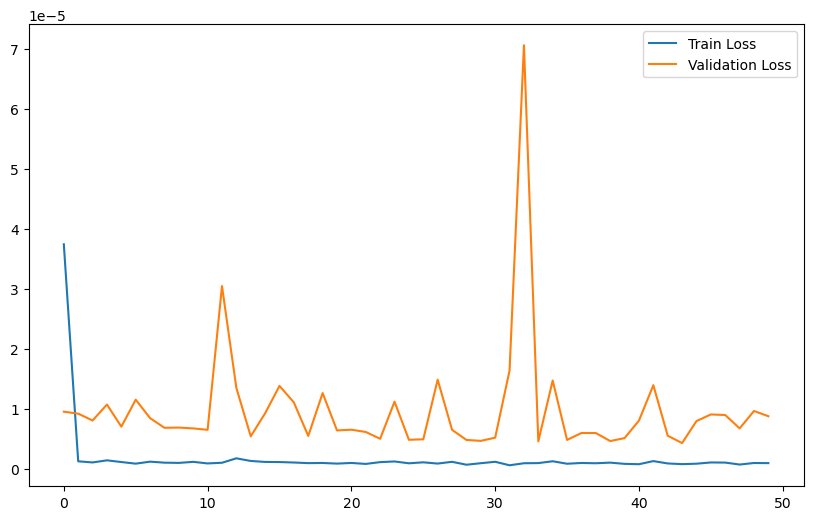

In [26]:
def plot_training_history(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

plot_training_history(history)

**Evaluate Model Performance**

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Mean Squared Error: 18.264244344608485


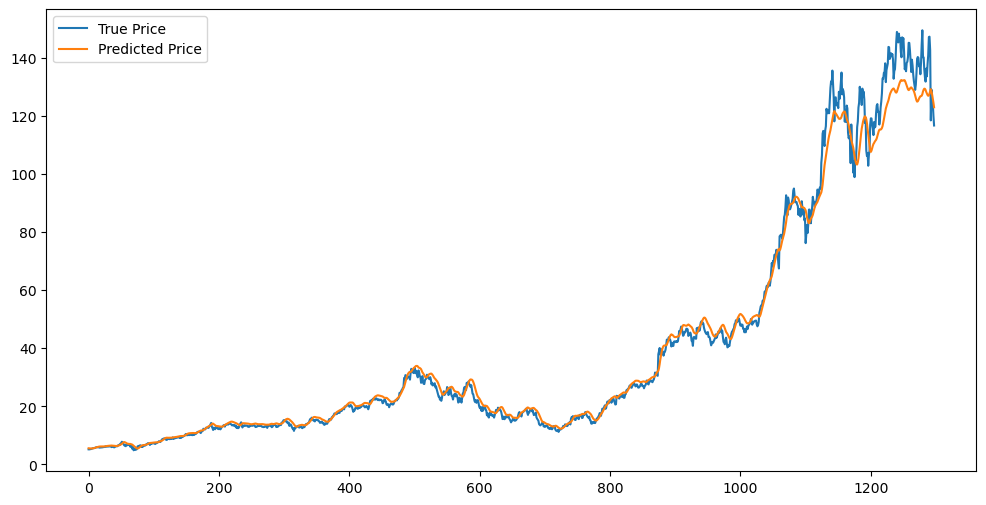

18.264244344608485

In [27]:
def evaluate_model(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1))
    y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    mse = mean_squared_error(y_test, predictions)
    print(f'Mean Squared Error: {mse}')

    plt.figure(figsize=(12,6))
    plt.plot(y_test, label='True Price')
    plt.plot(predictions, label='Predicted Price')
    plt.legend()
    plt.show()

    return mse

evaluate_model(model, X_test, y_test, scaler)